# GO enrichment with `goenrich`

In the following we will perform a gene ontology enrichment analysis using 'goenrich' and the example data provided by the published [`WebGestalt`](http://bioinfo.vanderbilt.edu/webgestalt/) tool.

### 1. run `WebGestalt`

First we can run `WebGestalt` on their website using the example data provided (`final_sig_file_XXX.tsv`). I wrote a small script `wegestalt.py` to parse their weird output format into something more convenient.

In [1]:
import webgestalt
web = webgestalt.read('../db/webgestalt_example_results/files/final_sig_file_1439064580.tsv')
web.head()

,C,E,GO_ID,O,R,adjP,name,namespace,rawP
0,1023,49.06,GO:0006468,93,1.90,8.130000e-07,protein phosphorylation,biological_process,4.460000e-10
1,1963,94.13,GO:0006796,149,1.58,8.130000e-07,phosphate-containing compound metabolic process,biological_process,5.370000e-10
2,2002,96.00,GO:0006793,150,1.56,1.200000e-06,phosphorus metabolic process,biological_process,1.190000e-09
3,1640,78.64,GO:0035556,127,1.61,4.170000e-06,intracellular signal transduction,biological_process,5.510000e-09
4,1687,80.90,GO:0009653,128,1.58,1.020000e-05,anatomical structure morphogenesis,biological_process,1.680000e-08


### 2. parse example into pandas

We need the `geneinfo` table in order to map the ids from `GeneID` to `Symbol`

In [2]:
import pandas as pd
geneinfo = pd.read_table('../db/Homo_sapiens.gene_info.gz', comment='#', usecols=[1,2], names=['GeneID', 'Symbol']) 
interesting = pd.read_table('../db/interestingGenes.txt', names=['Symbol']).merge(geneinfo)
reference = pd.read_table('../db/referenceGenes.txt', names=['Symbol']).merge(geneinfo)

### 3. build the ontology

Now we can move on to use `goenrich` to build the ontology DAG. Additionally we need the set of all GO annotation from `gene2go`.

In [3]:
import goenrich
O = goenrich.obo.ontology('../db/go-basic.obo')
gene2go = goenrich.read.gene2go('../db/gene2go.gz')

### 4. build the background-set and propagate

Using a small helper functon we can generate a background set from the `pandas.DataFrames` we parsed before. We use the background set to annotate our ontology. Because of the DAG structure of the ontology we can do so by first perfoming a topological sort on the ontology.

In [4]:
import goenrich.tools as tools
background = tools.generate_background(gene2go, reference, 'GO_ID', 'GeneID')
goenrich.enrich.propagate(O, background, 'reference')

### 5. run the query

Using the set of interesting genes as query we can perform our analysis. Additional options for filtering the categories we would like to test on can be passed to `analyze`. One might choose to extract small (`min_category_size`), too specific (`max_category_depth`) or too big/generic (`max_category_size`) categories.

The underlying test is the hypergeometric test `hypergeom.sf(x, M, n, N)`. All $p$-values are corrected for multiple testing using the Benjamini-Hochberge method before a significance cut-off of $\alpha=0.05$ is applied.

In [5]:
query = set(interesting['GeneID'])
options = { 'min_category_size' : 2, 'max_category_size' : 100000,
    'max_category_depth' : 100000 }
enrichment = goenrich.enrich.analyze(O, query, 'reference', **options).dropna().sort_values('q')
enrichment.head()

,M,N,n,name,namespace,p,q,rejected,term,x
26098,10808,484,518,protein kinase activity,molecular_function,1.392832e-19,1.648139e-15,1,GO:0004672,73
9247,10808,484,632,kinase activity,molecular_function,6.839273e-18,4.046456e-14,1,GO:0016301,79
34231,10808,484,590,"phosphotransferase activity, alcohol group as ...",molecular_function,1.916952e-17,7.561097e-14,1,GO:0016773,75
24064,10808,484,703,protein phosphorylation,biological_process,3.232890e-17,9.563697e-14,1,GO:0006468,83
9366,10808,484,1628,carbohydrate derivative binding,molecular_function,1.829513e-16,4.329726e-13,1,GO:0097367,141


### 6. comparison to `WebGestalt`

We can first look at the category sizes and intersections

`Webgestalt`: `C`, `O`

`goenrich`: `n`, `x`

In [6]:
df = pd.merge(enrichment, web)
df[['C', 'O', 'n', 'x']].head()

,C,O,n,x
0,528,74,518,73
1,642,79,632,79
2,606,76,590,75
3,1023,93,703,83
4,378,56,386,56


we can see come differences which might be due to different version of the `gene2go` annotation file, the ontology tree, or artifacts of the id mapping.

To quantify to consistency of both predictions we can therefore look at the correlation between the two

/data/miniconda3/envs/goenrich/lib/python2.7/site-packages/seaborn/linearmodels.py:1283: UserWarning: The `corrplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `corrplot` function has been deprecated in favor "
/data/miniconda3/envs/goenrich/lib/python2.7/site-packages/seaborn/linearmodels.py:1349: UserWarning: The `symmatplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `symmatplot` function has been deprecated in favor "


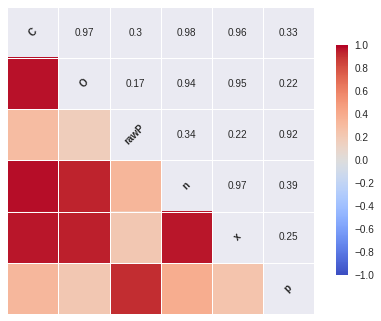

In [7]:
%matplotlib inline
import seaborn as sns
sns.corrplot(df[['C', 'O', 'rawP', 'n', 'x', 'p']], method='spearman')

The resulting correlation between `WebGestalt` and `goenrich` $p$-values is $0.92$